# Academy Award for Best Director

We first import the packages and load the csv files into dataframes

In [0]:
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
pd.options.mode.chained_assignment = None
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [0]:
url_template = 'https://raw.githubusercontent.com/dcetin/academy-awards/master/{}.csv'
df_bestactress  = pd.read_csv(url_template.format('best-actress'))
df_bestactor    = pd.read_csv(url_template.format('best-actor'))
df_bestdirector = pd.read_csv(url_template.format('best-director'))
df_ceremonies   = pd.read_csv(url_template.format('ceremonies'))

We convert dates into datetime objects, append them as new columns. We also calculate ages using the timedeltas.

In [0]:
def get_ceremony_date(df_ceremonies, i):
  return df_ceremonies.iloc[df_ceremonies[df_ceremonies['Ceremony'] == i].index[0]]['date_dt']
def get_age(df_ceremonies, ceremony, birthdate, fmt='days'):
  if fmt == 'days':
    return (get_ceremony_date(df_ceremonies, ceremony) - birthdate).days
  elif fmt == 'ymd':
    rd = relativedelta(get_ceremony_date(df_ceremonies, ceremony), birthdate)
    return '{}y{}m{}d'.format(rd.years, rd.months, rd.days)
  elif fmt == 'ym':
    rd = relativedelta(get_ceremony_date(df_ceremonies, ceremony), birthdate)
    return '{}y{}m'.format(rd.years, rd.months)
  elif fmt == 'float':
    rd = relativedelta(get_ceremony_date(df_ceremonies, ceremony), birthdate)
    return rd.years + (rd.months)/12.0 + (rd.days)/365.0

In [0]:
df_ceremonies['date_dt'] = pd.to_datetime(df_ceremonies['Date'].values, format='%B %d, %Y')
df_ceremonies['year'] = df_ceremonies.apply(lambda row: row['date_dt'].year, axis=1).copy()
for df in [df_bestactress, df_bestactor, df_bestdirector]:  
  df['birthdate_dt'] = pd.to_datetime(df['Birthdate'].values, format='%B %d, %Y')
  df['age_float'] = df.apply(lambda row: get_age(df_ceremonies, row['Ceremony'], row['birthdate_dt'], fmt='float'), axis=1)
  df['age_ym'] = df.apply(lambda row: get_age(df_ceremonies, row['Ceremony'], row['birthdate_dt'], fmt='ym'), axis=1)
xticks_pos, xticks_lab = list(range(1, len(df_ceremonies)+1, 3)), ["'" + str(x)[-2:] for x in df_ceremonies['year'][::3].values]

We calculate some statistics and extract some filters which will come in handy when plotting the data.

In [0]:
def process_df(df, title=''):
  data = {}
  data['nominees'] = df['Won'] == False
  data['winners'] = df['Won'] == True
  ages_per_ceremony = [df['age_float'][df['Ceremony']==i].values for i in range(1, len(df_ceremonies)+1)]
  data['means'] = np.asarray([np.mean(x) for x in ages_per_ceremony])
  data['medians'] = np.asarray([np.median(x) for x in ages_per_ceremony])
  stds = np.asarray([np.std(x) for x in ages_per_ceremony])
  df['color_nw'] = df.apply(lambda row: 'red' if row['Won'] else 'black', axis=1).copy()
  data['hovertext'] = df.apply(lambda row: '{}, {} ({}, {})'.format(row['Name'], row['age_ym'], row['Film'], 
                                                    get_ceremony_date(df_ceremonies, row['Ceremony']).year), axis=1).copy()
  data['df'] = df
  data['title'] = title
  return data

In [0]:
data_bestactress  = process_df(df_bestactress, title='Academy Award for Best Actress')
data_bestactor    = process_df(df_bestactor, title='Academy Award for Best Actor')
data_bestdirector = process_df(df_bestdirector, title='Academy Award for Best Director')

We plot the winners and nominees by their age at the day of the award ceremony. 

In [7]:
# Initialize figure
fig = go.Figure()

# Data dictionary for the default plot is placed first
data_list = [data_bestdirector, data_bestactress, data_bestactor]
toggle_active = [True, True, 'legendonly', 'legendonly']

# Add Traces to figure
for idx, data in enumerate(data_list):
  vis = (True, 'legendonly') if idx is 0 else (False, False)
  df, winners, nominees, hovertext = data['df'], data['winners'], data['nominees'], data['hovertext']
  fig.add_trace(go.Scatter(x=df['Ceremony'][nominees], y=df['age_float'][nominees], mode='markers', visible=vis[0], 
   marker_color=df['color_nw'][nominees], hoverinfo="text", hovertext=hovertext[nominees], name="Nominees"))
  fig.add_trace(go.Scatter(x=df['Ceremony'][winners], y=df['age_float'][winners], mode='markers', visible=vis[0], 
   marker_color=df['color_nw'][winners], hoverinfo="text", hovertext=hovertext[winners], name="Winners"))
  fig.add_trace(go.Scatter(x=df_ceremonies['Ceremony'], y=data['medians'], marker_color='green', name="Medians", hoverinfo='y', visible=vis[1]))
  fig.add_trace(go.Scatter(x=df_ceremonies['Ceremony'], y=data['means'], marker_color='blue', name="Means", hoverinfo='y', visible=vis[1]))
  toggle_new = [False] * len(toggle_active) * len(data_list)
  toggle_new[idx*len(toggle_active):(idx+1)*len(toggle_active)] = toggle_active
  data['toggle'] = toggle_new

# Set update rules for the dropdown button
fig.update_layout(title_text=data_list[0]['title'])
fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            type = "buttons",
            active=0,
            buttons=list([
                dict(label="Best Director", method="update",
                     args=[{"visible": data_bestdirector['toggle']},
                           {"title": data_bestdirector['title']}]),
                dict(label="Best Actress", method="update",
                     args=[{"visible": data_bestactress['toggle']},
                           {"title": data_bestactress['title']}]),
                dict(label="Best Actor", method="update",
                     args=[{"visible": data_bestactor['toggle']},
                           {"title": data_bestactor['title']}]),
            ]),
        )
    ])

# Set axes
fig.update_yaxes(zeroline=False, title='Age')
fig.update_xaxes(zeroline=False, title='Year', tickvals=xticks_pos, ticktext=xticks_lab)

# Show figure
fig.show()

In [8]:
plotly.offline.plot(fig, filename='academy-awards.html')

'academy-awards.html'

Creating separate dynamic plots.

In [0]:
def plot_people(data, show_plot=True):
  df, winners, nominees, hovertext = data['df'], data['winners'], data['nominees'], data['hovertext']
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=df['Ceremony'][nominees], y=df['age_float'][nominees], 
                            mode='markers', marker_color=df['color_nw'][nominees], 
                            hoverinfo="text", hovertext=hovertext[nominees], name="Nominees"))
  fig.add_trace(go.Scatter(x=df['Ceremony'][winners], y=df['age_float'][winners], 
                          mode='markers', marker_color=df['color_nw'][winners], 
                          hoverinfo="text", hovertext=hovertext[winners], name="Winners"))
  fig.add_trace(go.Scatter(x=df_ceremonies['Ceremony'], y=data['medians'], marker_color='green', name="Medians", hoverinfo='y', visible='legendonly'))
  fig.add_trace(go.Scatter(x=df_ceremonies['Ceremony'], y=data['means'], marker_color='blue', name="Means", hoverinfo='y', visible='legendonly'))
  fig.update_layout(title=data['title'])
  fig.update_yaxes(zeroline=False, title='Age')
  fig.update_xaxes(zeroline=False, title='Year', tickvals=xticks_pos, ticktext=xticks_lab)
  if show_plot is False:
    return fig
  fig.show()
  return fig

In [10]:
fig_bestactress  = plot_people(data_bestactress)
fig_bestactor    = plot_people(data_bestactor)
fig_bestdirector = plot_people(data_bestdirector)

In [0]:
figs  = [fig_bestactress, fig_bestactor, fig_bestdirector]
divs  = [plotly.offline.plot(fig, include_plotlyjs=False, output_type='div') for fig in figs]
names = ['fig_bestactress', 'fig_bestactor', 'fig_bestdirector']
htmls = [plotly.offline.plot(fig, filename= name + '.html') for (fig, name) in zip(figs, names)]

Searching for a specific director in the static plot.

In [0]:
#@title String fields
name = 'Meryl Streep' #@param {type:"string"}
dataset = 'Best Actress' #@param ["Best Director", "Best Actress", "Best Actor"]
dfs = {'Best Director': df_bestdirector, 'Best Actress': df_bestactress, 'Best Actor': df_bestactor}
df = dfs[dataset]

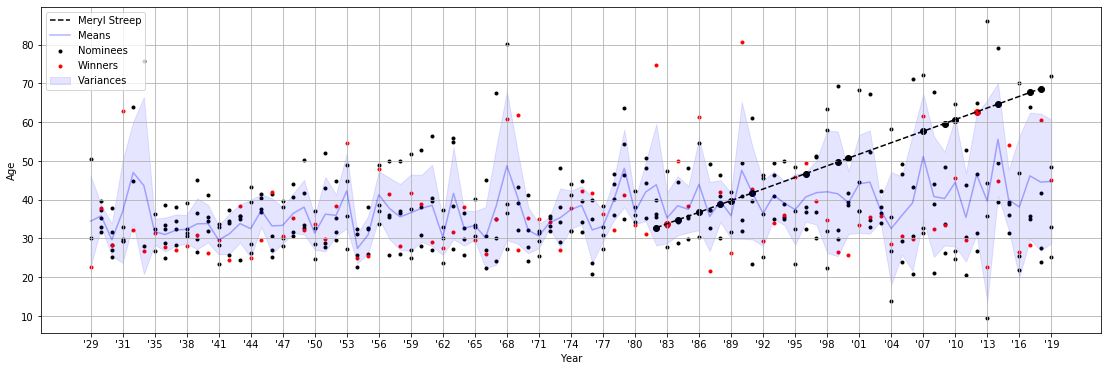

In [13]:
nominees = df['Won'] == False
winners = df['Won'] == True
ages_per_ceremony = [df['age_float'][df['Ceremony']==i].values for i in range(1, len(df_ceremonies)+1)]
means = np.asarray([np.mean(x) for x in ages_per_ceremony])
medians = np.asarray([np.median(x) for x in ages_per_ceremony])
stds = np.asarray([np.std(x) for x in ages_per_ceremony])
xticks_pos, xticks_lab = list(range(1, len(df_ceremonies)+1, 3)), ["'" + str(x)[-2:] for x in df_ceremonies['year'][::3].values]

specifier = df['Name'] == name
plt.figure(figsize=(19,6))
plt.scatter(df['Ceremony'][nominees], df['age_float'][nominees], marker='.', c='k', label='Nominees')
plt.scatter(df['Ceremony'][winners], df['age_float'][winners], marker='.', c='r', label='Winners')
plt.plot(df['Ceremony'][specifier], df['age_float'][specifier], linestyle='--', c='k', label=name)
plt.scatter(df['Ceremony'][nominees & specifier], df['age_float'][nominees & specifier], c='k', label='_nolegend_')
plt.scatter(df['Ceremony'][winners & specifier], df['age_float'][winners & specifier], c='r', label='_nolegend_')
plt.plot(df_ceremonies['Ceremony'], means, linestyle='-', c='b', alpha=0.3, label='Means')
# plt.plot(df_ceremonies['Ceremony'], medians, linestyle='-', c='g', alpha=0.7, label='Medians')
plt.fill_between(df_ceremonies['Ceremony'], means-stds, means+stds, color='b', alpha=0.1, label='Variances')
plt.xticks(xticks_pos, xticks_lab)
plt.grid(True)
plt.ylabel('Age')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.show()

Lack of female directors.

In [0]:
female_dirs = ['Lina Wertmuller', 'Jane Campion', 'Sofia Coppola', 'Kathryn Bigelow', 'Greta Gerwig']
females = df_bestdirector['Name'].isin(female_dirs)
df_bestdirector['color_mf'] = df_bestdirector.apply(lambda row: 'red' if row['Name'] in female_dirs else 'blue', axis=1).copy()